# Edge detection

In [ ]:
import pydicom
import matplotlib.pyplot as plt

# Ruta al archivo DICOM
ruta_dcm = "C:/Users/ritaj/Downloads/OCTImage_2025_07_18_08-57-12.dcm"  # Cambia esto por la ruta real

# Leer el archivo DICOM
ds = pydicom.dcmread(ruta_dcm)

# Extraer los datos de imagen como array NumPy
imagen = ds.pixel_array

# Mostrar la imagen
plt.imshow(imagen, cmap='gray')
plt.title("Imagen DICOM")
plt.axis('off')
plt.show()

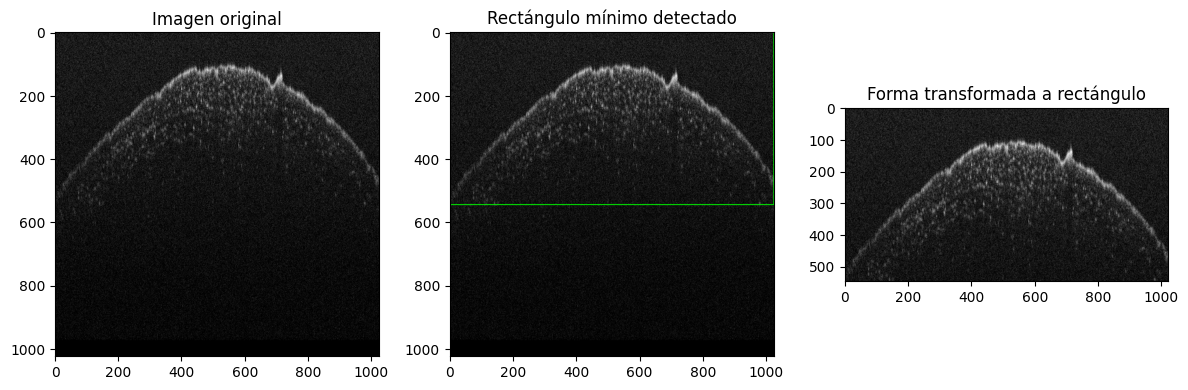

In [8]:
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Leer DICOM
ruta = r"C:\Users\ritaj\Downloads\OCTImage_2025_07_18_08-57-12.dcm"
ds = pydicom.dcmread(ruta)
img = ds.pixel_array.astype(np.float32)

# Normalizar a 8 bits
img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Suavizado y umbral para binarizar forma blanca (rábano)
_, thresh = cv2.threshold(img_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Encontrar contorno más grande
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if not contours:
    raise ValueError("No se encontró ninguna forma.")

cnt = max(contours, key=cv2.contourArea)

# Obtener el rectángulo rotado mínimo
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.intp(box)  # esquinas del rábano

# Ordenar puntos del rectángulo
def ordenar_puntos(pts):
    pts = pts[np.argsort(pts[:, 1])]  # ordenar por y
    top, bottom = pts[:2], pts[2:]
    top = top[np.argsort(top[:, 0])]
    bottom = bottom[np.argsort(bottom[:, 0])]
    return np.array([top[0], top[1], bottom[1], bottom[0]], dtype='float32')

src_pts = ordenar_puntos(box)

# Dimensiones del nuevo rectángulo (puedes ajustarlas si quieres)
width = int(max(np.linalg.norm(src_pts[0] - src_pts[1]), np.linalg.norm(src_pts[2] - src_pts[3])))
height = int(max(np.linalg.norm(src_pts[0] - src_pts[3]), np.linalg.norm(src_pts[1] - src_pts[2])))

dst_pts = np.array([
    [0, 0],
    [width - 1, 0],
    [width - 1, height - 1],
    [0, height - 1]
], dtype='float32')

# Transformación de perspectiva
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warped = cv2.warpPerspective(img_norm, M, (width, height))

# Mostrar resultados
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_norm, cmap='gray')
plt.title("Imagen original")

img_box = cv2.cvtColor(img_norm.copy(), cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_box, [box], 0, (0, 255, 0), 2)

plt.subplot(1, 3, 2)
plt.imshow(img_box)
plt.title("Rectángulo mínimo detectado")

plt.subplot(1, 3, 3)
plt.imshow(warped, cmap='gray')
plt.title("Forma transformada a rectángulo")

plt.tight_layout()
plt.show()


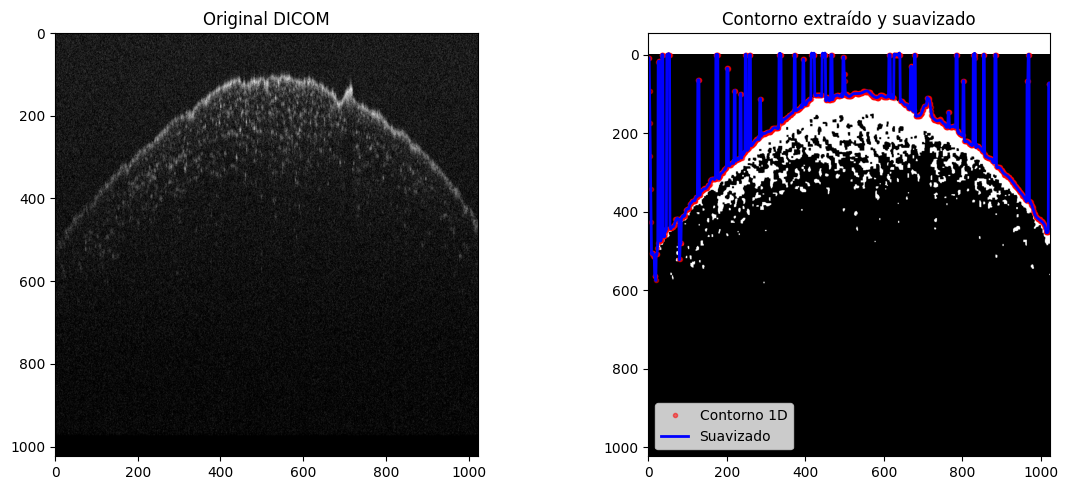

In [10]:
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# === 1. Leer y normalizar imagen DICOM ===
ruta = r"C:\Users\ritaj\Downloads\OCTImage_2025_07_18_08-57-12.dcm"
ds = pydicom.dcmread(ruta)
img = ds.pixel_array.astype(np.float32)
img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# === 2. Filtro robusto para eliminar ruido (mediana o bilateral) ===
denoised = cv2.medianBlur(img_norm, 5)  # buena contra sal y pimienta
# Alternativa: denoised = cv2.bilateralFilter(img_norm, 9, 75, 75)

# === 3. Umbral Otsu + operaciones morfológicas para limpiar ===
_, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Limpiar regiones pequeñas o agujeros
kernel = np.ones((3, 3), np.uint8)
binary_clean = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
binary_clean = cv2.morphologyEx(binary_clean, cv2.MORPH_OPEN, kernel, iterations=1)

# === 4. Extraer contorno superior como señal 1D ===
height, width = binary_clean.shape
top_edge = np.zeros(width)

for x in range(width):
    col = binary_clean[:, x]
    white_pixels = np.where(col > 0)[0]
    top_edge[x] = white_pixels[0] if len(white_pixels) > 0 else np.nan

# === 5. Rellenar NaNs por interpolación lineal ===
x_vals = np.arange(width)
valid = ~np.isnan(top_edge)
top_interp = np.interp(x_vals, x_vals[valid], top_edge[valid])

# === 6. Suavizado tipo García ===
spline = UnivariateSpline(x_vals, top_interp, s=width*2)
smoothed_edge = spline(x_vals)

# === 7. Visualización completa ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_norm, cmap='gray')
plt.title("Original DICOM")

plt.subplot(1, 2, 2)
plt.imshow(binary_clean, cmap='gray')
plt.plot(x_vals, top_interp, 'r.', alpha=0.5, label="Contorno 1D")
plt.plot(x_vals, smoothed_edge, 'b-', linewidth=2, label="Suavizado")
plt.title("Contorno extraído y suavizado")
plt.legend()

plt.tight_layout()
plt.show()


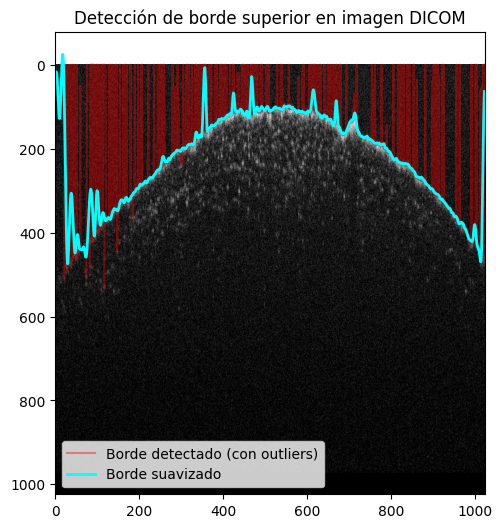

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from smoothn import smoothn  # asegúrate de tener smoothn.py en la misma carpeta

# === 1. Cargar imagen DICOM ===
ruta = r"C:\Users\ritaj\Downloads\OCTImage_2025_07_18_08-57-12.dcm"
ds = pydicom.dcmread(ruta)
img = ds.pixel_array.astype(float)

# Normalizar
img = img / np.max(img)

# === 2. Detección del borde superior (primera fila con intensidad > umbral por columna) ===
umbral = 0.3  # Puedes ajustar esto
h, w = img.shape
perfil = np.zeros(w)

for col in range(w):
    columna = img[:, col]
    filas_candidatas = np.where(columna > umbral)[0]
    perfil[col] = filas_candidatas[0] if filas_candidatas.size > 0 else np.nan

# === 3. Detectar outliers (saltos grandes entre columnas) ===
dif = np.abs(np.diff(perfil))
q1, q3 = np.percentile(dif[~np.isnan(dif)], [25, 75])
iqr = q3 - q1
umbral_outlier = q3 + 1.5 * iqr

outlier_mask = np.zeros_like(perfil, dtype=bool)
outlier_mask[1:] = dif > umbral_outlier
perfil_clean = perfil.copy()
perfil_clean[outlier_mask] = np.nan

# === 4. Suavizar perfil y rellenar outliers con smoothn ===
perfil_suavizado = smoothn(perfil_clean, robust=True)

# === 5. Mostrar resultados ===
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img, cmap='gray')
ax.plot(perfil, label='Borde detectado (con outliers)', color='red', alpha=0.4)
ax.plot(perfil_suavizado, label='Borde suavizado', color='cyan', linewidth=2)
ax.legend()
ax.set_title("Detección de borde superior en imagen DICOM")
plt.show()


Perfil borde detectado (con outliers):
[ 40.  nan  nan ... 461.  76.   0.]
Perfil borde sin outliers (NaN en outliers):
[40. nan nan ... nan nan  0.]
Perfil borde suavizado:
[ 36.13145794  29.4104993   21.40417223 ... 138.55202711  90.0245027
  63.70604637]


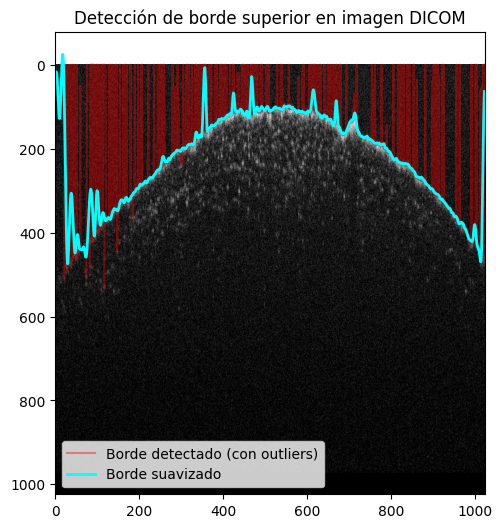

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from smoothn import smoothn  # asegúrate de tener smoothn.py en la misma carpeta

# === 1. Cargar imagen DICOM ===
ruta = r"C:\Users\ritaj\Downloads\OCTImage_2025_07_18_08-57-12.dcm"
ds = pydicom.dcmread(ruta)
img = ds.pixel_array.astype(float)

# Normalizar
img = img / np.max(img)

# === 2. Detección del borde superior (primera fila con intensidad > umbral por columna) ===
umbral = 0.3  # Puedes ajustar esto
h, w = img.shape
perfil = np.zeros(w)

for col in range(w):
    columna = img[:, col]
    filas_candidatas = np.where(columna > umbral)[0]
    perfil[col] = filas_candidatas[0] if filas_candidatas.size > 0 else np.nan

print("Perfil borde detectado (con outliers):")
print(perfil)

# === 3. Detectar outliers (saltos grandes entre columnas) ===
dif = np.abs(np.diff(perfil))
q1, q3 = np.percentile(dif[~np.isnan(dif)], [25, 75])
iqr = q3 - q1
umbral_outlier = q3 + 1.5 * iqr

outlier_mask = np.zeros_like(perfil, dtype=bool)
outlier_mask[1:] = dif > umbral_outlier
perfil_clean = perfil.copy()
perfil_clean[outlier_mask] = np.nan

print("Perfil borde sin outliers (NaN en outliers):")
print(perfil_clean)

# === 4. Suavizar perfil y rellenar outliers con smoothn ===
perfil_suavizado = smoothn(perfil_clean, robust=True)

print("Perfil borde suavizado:")
print(perfil_suavizado)

# === 5. Mostrar resultados ===
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img, cmap='gray')
ax.plot(perfil, label='Borde detectado (con outliers)', color='red', alpha=0.4)
ax.plot(perfil_suavizado, label='Borde suavizado', color='cyan', linewidth=2)
ax.legend()
ax.set_title("Detección de borde superior en imagen DICOM")
plt.show()


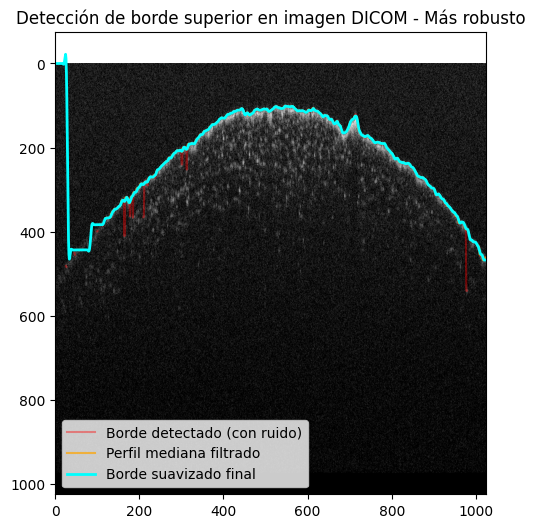

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from smoothn import smoothn  # asegúrate de tener smoothn.py en la misma carpeta
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt

# === 1. Cargar imagen DICOM ===
ruta = r"C:\Users\ritaj\Downloads\OCTImage_2025_07_18_08-57-12.dcm"
ds = pydicom.dcmread(ruta)
img = ds.pixel_array.astype(float)

# Normalizar
img = img / np.max(img)

# === 2. Suavizar imagen con filtro Gaussiano para reducir ruido ===
img_suave = gaussian_filter(img, sigma=1)  # Ajusta sigma según ruido

# === 3. Detección del borde superior en imagen suavizada ===
umbral = 0.3  # Ajusta según imagen
h, w = img.shape
perfil = np.zeros(w)

for col in range(w):
    columna = img_suave[:, col]
    filas_candidatas = np.where(columna > umbral)[0]
    perfil[col] = filas_candidatas[0] if filas_candidatas.size > 0 else np.nan

# === 4. Aplicar filtro mediana para eliminar picos aislados ===
perfil_filtrado = medfilt(perfil, kernel_size=5)  # Ajusta tamaño ventana

# === 5. Detectar outliers basados en saltos grandes entre columnas ===
dif = np.abs(np.diff(perfil_filtrado))
q1, q3 = np.percentile(dif[~np.isnan(dif)], [25, 75])
iqr = q3 - q1
umbral_outlier = q3 + 1.5 * iqr

outlier_mask = np.zeros_like(perfil_filtrado, dtype=bool)
outlier_mask[1:] = dif > umbral_outlier

perfil_clean = perfil_filtrado.copy()
perfil_clean[outlier_mask] = np.nan  # Marcar outliers como NaN

# === 6. Suavizar perfil limpio y rellenar NaN con smoothn ===
perfil_suavizado = smoothn(perfil_clean, robust=True)

# === 7. Mostrar resultados ===
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img, cmap='gray')
ax.plot(perfil, label='Borde detectado (con ruido)', color='red', alpha=0.4)
ax.plot(perfil_filtrado, label='Perfil mediana filtrado', color='orange', alpha=0.7)
ax.plot(perfil_suavizado, label='Borde suavizado final', color='cyan', linewidth=2)
ax.legend()
ax.set_title("Detección de borde superior en imagen DICOM - Más robusto")
plt.show()


In [39]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from pathlib import Path
from smoothn import smoothn

from skimage.filters import threshold_otsu
from skimage.measure import label, find_contours
from skimage.morphology import remove_small_objects
from scipy.interpolate import UnivariateSpline
from imageio import imwrite

# Configuraciones del usuario
FILE = "C:/Users/ritaj/Downloads/OCTImage_2025_07_18_08-57-12.dcm"  # ruta a la imagen DICOM
AUTO_S = True         # GCV automático
FIXED_S = 1.04        # usado si AUTO_S es False
ROBUST = True         # smoothn robusto
MIN_OBJ = 5000        # tamaño mínimo de componente conectado
SAVE_PNG = False      # cambia a True si deseas guardar
EDGE_NPTS = 30        # columnas usadas para extrapolación
SPL_SMOOTH_FACTOR = 0.5  # suavizado spline (0 = interp)
dicom_path = Path(FILE)
ds = pydicom.dcmread(dicom_path)
img = ds.pixel_array.astype(float)
print("Imagen cargada:", img.shape, img.dtype)


Imagen cargada: (1024, 1024) float64


In [40]:
if AUTO_S:
    img_s, s = smoothn(img, robust=ROBUST, return_s=True)
    s_used = float(np.asarray(s))
else:
    img_s = smoothn(img, s=FIXED_S, robust=ROBUST)
    s_used = FIXED_S

print(f"Parámetro de suavizado s: {s_used:.4g}")

res = img - img_s
res_ratio = float(np.std(res) / np.std(img))
res_max = float(np.abs(res).max())

print("STD residuo / STD original:", res_ratio)
print("Máximo residuo absoluto:", res_max)


Parámetro de suavizado s: 1.043
STD residuo / STD original: 0.5941106484028912
Máximo residuo absoluto: 42843.632850342605


C:\Users\ritaj\AppData\Local\Temp\ipykernel_12144\2104094140.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s_used = float(np.asarray(s))


In [41]:
thr = threshold_otsu(img_s)
mask = img_s > thr

lab = label(mask)
if lab.max() > 0:
    sizes = np.bincount(lab.ravel())
    sizes[0] = 0
    biggest = sizes.argmax()
    mask = (lab == biggest)
    mask = remove_small_objects(mask, MIN_OBJ)

mean_intensity = float(img_s[mask].mean())
area_px = int(mask.sum())

print(f"Intensidad media dentro del rábano: {mean_intensity:.2f}")
print(f"Área segmentada (px): {area_px}")


Intensidad media dentro del rábano: 20586.71
Área segmentada (px): 53088


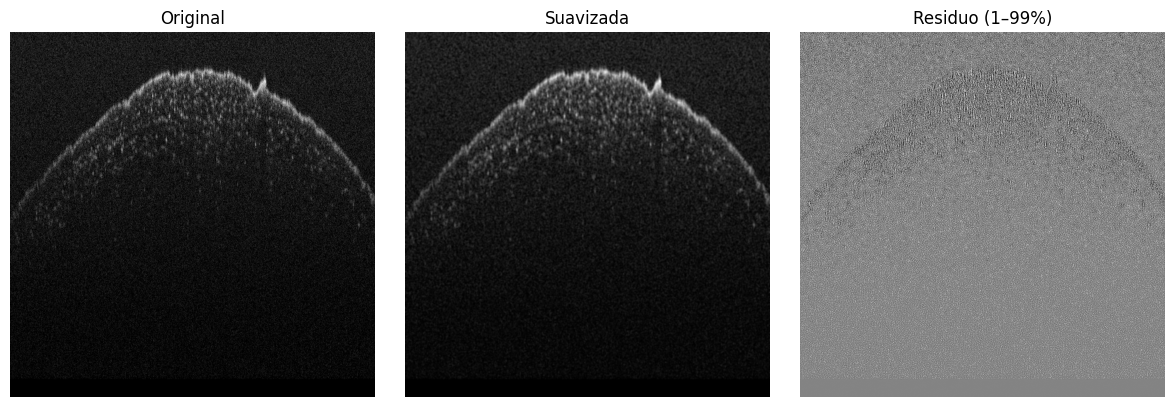

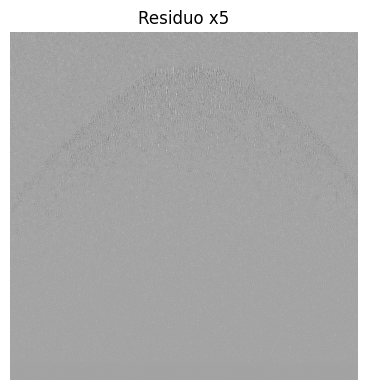

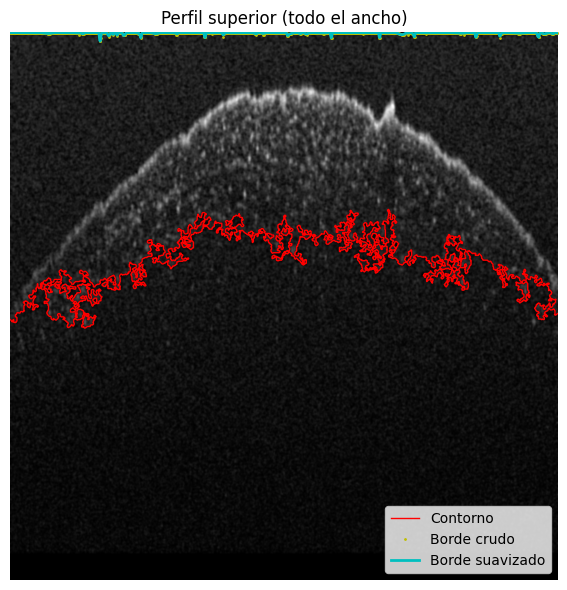

In [38]:
contours = find_contours(mask.astype(float), level=0.5)
contour = max(contours, key=len) if contours else np.empty((0, 2))

rows, cols = np.where(mask)
top_y = {}
for r, c in zip(rows, cols):
    if c not in top_y or r < top_y[c]:
        top_y[c] = r

xs_known = np.array(sorted(top_y.keys()))
ys_known = np.array([top_y[x] for x in xs_known])

W = img_s.shape[1]
xs_full = np.arange(W)

if xs_known.size > 3:
    spl = UnivariateSpline(xs_known, ys_known, s=len(xs_known)*SPL_SMOOTH_FACTOR)
    ys_spline = spl(xs_full)
else:
    spl = None
    ys_spline = np.interp(xs_full, xs_known, ys_known)

def edge_fit(x_arr, y_arr, side='left'):
    n = min(EDGE_NPTS, x_arr.size)
    if side == 'left':
        xseg = x_arr[:n]; yseg = y_arr[:n]
    else:
        xseg = x_arr[-n:]; yseg = y_arr[-n:]
    m, b = np.polyfit(xseg, yseg, 1)
    return m, b

m_left, b_left = edge_fit(xs_known, ys_known, 'left')
m_right, b_right = edge_fit(xs_known, ys_known, 'right')

ys_full = ys_spline.copy()
left_end = xs_known.min()
right_end = xs_known.max()

xsL = np.arange(0, left_end)
ys_full[xsL] = m_left * xsL + b_left

xsR = np.arange(right_end+1, W)
ys_full[xsR] = m_right * xsR + b_right

ys_full = np.clip(ys_full, 0, img_s.shape[0]-1)
# Panel 1: original, suavizada y residuo
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img, cmap='gray'); ax[0].set_title("Original"); ax[0].axis('off')
ax[1].imshow(img_s, cmap='gray'); ax[1].set_title("Suavizada"); ax[1].axis('off')
ax[2].imshow(res, cmap='gray', vmin=np.percentile(res,1), vmax=np.percentile(res,99))
ax[2].set_title("Residuo (1–99%)"); ax[2].axis('off')
plt.tight_layout(); plt.show()

# Residuo amplificado
plt.figure(figsize=(4, 4))
plt.imshow(res*5, cmap='gray'); plt.title("Residuo x5"); plt.axis('off')
plt.tight_layout(); plt.show()

# Contorno + línea superior
fig3, ax3 = plt.subplots(figsize=(6,6))
ax3.imshow(img_s, cmap='gray')
if contour.size:
    ax3.plot(contour[:,1], contour[:,0], '-r', lw=1, label='Contorno')
ax3.plot(xs_known, ys_known, '.y', ms=2, label='Borde crudo')
ax3.plot(xs_full, ys_full, '-c', lw=2, label='Borde suavizado')
ax3.legend(loc='lower right')
ax3.set_title("Perfil superior (todo el ancho)")
ax3.axis('off')
plt.tight_layout(); plt.show()



In [2]:
"""
radish_folder.py
----------------
Procesa todos los DICOM en una carpeta con el mismo flujo que radish_full.py
"""

from pathlib import Path
import numpy as np
import pydicom
import matplotlib.pyplot as plt

from smoothn import smoothn
from skimage.filters import threshold_otsu
from skimage.measure import label, find_contours
from skimage.morphology import remove_small_objects
from scipy.interpolate import UnivariateSpline
from imageio import imwrite

# -------------------- USER SETTINGS --------------------
FOLDER         = r"C:/Users/ritaj/Documents/R/Rabanitos/imagenes"  # carpeta con DICOMs
OUTPUT_FOLDER  = r"C:/Users/ritaj/Documents/R/Rabanitos/salida"    # carpeta para guardar imágenes PNG
AUTO_S         = True         # True = auto GCV; False = usar FIXED_S
FIXED_S        = 1.04         # usado sólo si AUTO_S es False
ROBUST         = True         # iteración robusta (más lento)
MIN_OBJ        = 5000         # min pixeles para objetos
SAVE_PNG       = True         # guardar PNGs de salida
EDGE_NPTS      = 30           # columnas en extremos para estimar pendiente
SPL_SMOOTH_FACTOR = 0.5       # factor suavizado spline
# -------------------------------------------------------

def process_dicom(dicom_path: Path):
    print(f"\nProcesando: {dicom_path.name}")

    # 1) Load DICOM
    ds  = pydicom.dcmread(dicom_path)
    img = ds.pixel_array.astype(float)
    print("Image:", img.shape, img.dtype)

    # 2) Smooth
    if AUTO_S:
        img_s, s = smoothn(img, robust=ROBUST, return_s=True)
        s_used = float(np.asarray(s))
    else:
        img_s  = smoothn(img, s=FIXED_S, robust=ROBUST)
        s_used = FIXED_S
    print(f"Chosen s: {s_used:.4g}")

    # 3) Residual stats
    res = img - img_s
    res_ratio = float(np.std(res) / np.std(img))
    res_max   = float(np.abs(res).max())
    print("Residual std / original std:", res_ratio)
    print("Max abs residual:", res_max)

    # 4) Segment (Otsu + largest component)
    thr  = threshold_otsu(img_s)
    mask = img_s > thr

    lab = label(mask)
    if lab.max() > 0:
        sizes = np.bincount(lab.ravel())
        sizes[0] = 0
        biggest = sizes.argmax()
        mask = (lab == biggest)
        mask = remove_small_objects(mask, MIN_OBJ)

    mean_intensity = float(img_s[mask].mean())
    area_px        = int(mask.sum())
    print(f"Mean intensity (inside radish): {mean_intensity:.2f}")
    print(f"Area (pixels): {area_px}")

    # 5) Contour & full-width top line
    contours = find_contours(mask.astype(float), level=0.5)
    contour = max(contours, key=len) if contours else np.empty((0, 2))

    rows, cols = np.where(mask)
    top_y = {}
    for r, c in zip(rows, cols):
        if c not in top_y or r < top_y[c]:
            top_y[c] = r

    xs_known = np.array(sorted(top_y.keys()))
    ys_known = np.array([top_y[x] for x in xs_known])

    W = img_s.shape[1]
    xs_full = np.arange(W)

    # spline over known region
    if xs_known.size > 3:
        spl = UnivariateSpline(xs_known, ys_known,
                               s=len(xs_known)*SPL_SMOOTH_FACTOR)
        ys_spline = spl(xs_full)
    else:
        spl = None
        ys_spline = np.interp(xs_full, xs_known, ys_known)

    # Linear edge extrapolation
    def edge_fit(x_arr, y_arr, side='left'):
        n = min(EDGE_NPTS, x_arr.size)
        if side == 'left':
            xseg = x_arr[:n]; yseg = y_arr[:n]
        else:
            xseg = x_arr[-n:]; yseg = y_arr[-n:]
        m, b = np.polyfit(xseg, yseg, 1)
        return m, b

    m_left, b_left  = edge_fit(xs_known, ys_known, 'left')
    m_right, b_right = edge_fit(xs_known, ys_known, 'right')

    ys_full = ys_spline.copy()

    left_end  = xs_known.min()
    right_end = xs_known.max()

    xsL = np.arange(0, left_end)
    ys_full[xsL] = m_left * xsL + b_left

    xsR = np.arange(right_end+1, W)
    ys_full[xsR] = m_right * xsR + b_right

    ys_full = np.clip(ys_full, 0, img_s.shape[0]-1)

    # 6) Plots
    filename_stem = dicom_path.stem
    outdir = Path(OUTPUT_FOLDER)
    outdir.mkdir(parents=True, exist_ok=True)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(img,   cmap='gray'); ax[0].set_title("Original");  ax[0].axis('off')
    ax[1].imshow(img_s, cmap='gray'); ax[1].set_title("Smoothed");  ax[1].axis('off')
    ax[2].imshow(res,   cmap='gray',
                 vmin=np.percentile(res, 1),
                 vmax=np.percentile(res, 99))
    ax[2].set_title("Residual (1–99% clip)"); ax[2].axis('off')
    plt.tight_layout()
    if SAVE_PNG:
        png1 = outdir / f"{filename_stem}.preview.png"
        fig.savefig(png1, dpi=200)
        print("Saved", png1)
    plt.close(fig)

    fig2 = plt.figure(figsize=(4,4))
    plt.imshow(res*5, cmap='gray'); plt.title('Residual x5'); plt.axis('off')
    plt.tight_layout()
    if SAVE_PNG:
        png2 = outdir / f"{filename_stem}.residualx5.png"
        fig2.savefig(png2, dpi=200)
        print("Saved", png2)
    plt.close(fig2)

    fig3, ax3 = plt.subplots(figsize=(6,6))
    ax3.imshow(img_s, cmap='gray')
    if contour.size:
        ax3.plot(contour[:,1], contour[:,0], '-r', lw=1, label='Contour')
    ax3.plot(xs_known, ys_known, '.y', ms=2, label='Top raw (mask)')
    ax3.plot(xs_full, ys_full, '-c', lw=2, label='Top smooth (edge-to-edge)')
    ax3.legend(loc='lower right')
    ax3.set_title("Radish outline & full-width top line (improved edges)")
    ax3.axis('off')
    plt.tight_layout()
    if SAVE_PNG:
        png3 = outdir / f"{filename_stem}.contour.png"
        fig3.savefig(png3, dpi=200)
        print("Saved", png3)
    plt.close(fig3)

    # Optional cropped image save
    ys_idx, xs_idx = np.where(mask)
    if ys_idx.size:
        ymin, ymax = ys_idx.min(), ys_idx.max()
        xmin, xmax = xs_idx.min(), xs_idx.max()
        cropped = img_s[ymin:ymax+1, xmin:xmax+1]
        if SAVE_PNG:
            crop_png = outdir / f"{filename_stem}.cropped.png"
            imwrite(crop_png, (cropped / cropped.max() * 255).astype(np.uint8))
            print("Saved cropped image:", crop_png)

def main():
    folder = Path(FOLDER)
    Path(OUTPUT_FOLDER).mkdir(parents=True, exist_ok=True)
    dicom_files = sorted(folder.glob('*.dcm'))  # puedes ajustar la extensión si necesitas
    print(f"Encontrados {len(dicom_files)} archivos DICOM en {folder}")

    for dicom_file in dicom_files:
        try:
            process_dicom(dicom_file)
        except Exception as e:
            print(f"Error procesando {dicom_file.name}: {e}")

if __name__ == '__main__':
    main()

Encontrados 1359 archivos DICOM en C:\Users\ritaj\Documents\R\Rabanitos\imagenes

Procesando: OCTImage_2025_07_01_12-21-46.dcm
Image: (1024, 1024) float64


C:\Users\ritaj\AppData\Local\Temp\ipykernel_20364\3249898869.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s_used = float(np.asarray(s))


Chosen s: 1.406
Residual std / original std: 0.4457665638721596
Max abs residual: 42173.99144630085
Mean intensity (inside radish): 21739.76
Area (pixels): 95177
Saved C:\Users\ritaj\Documents\R\Rabanitos\salida\OCTImage_2025_07_01_12-21-46.preview.png
Saved C:\Users\ritaj\Documents\R\Rabanitos\salida\OCTImage_2025_07_01_12-21-46.residualx5.png
Saved C:\Users\ritaj\Documents\R\Rabanitos\salida\OCTImage_2025_07_01_12-21-46.contour.png
Saved cropped image: C:\Users\ritaj\Documents\R\Rabanitos\salida\OCTImage_2025_07_01_12-21-46.cropped.png

Procesando: OCTImage_2025_07_01_12-22-03.dcm
Image: (1024, 1024) float64
Chosen s: 0.7522
Residual std / original std: 0.48416147139047533
Max abs residual: 42238.27210920219
Mean intensity (inside radish): 18958.60
Area (pixels): 84325
Saved C:\Users\ritaj\Documents\R\Rabanitos\salida\OCTImage_2025_07_01_12-22-03.preview.png
Saved C:\Users\ritaj\Documents\R\Rabanitos\salida\OCTImage_2025_07_01_12-22-03.residualx5.png
Saved C:\Users\ritaj\Documents\R\

KeyboardInterrupt: 

In [13]:
from pathlib import Path
import numpy as np
import pydicom
import matplotlib.pyplot as plt

from smoothn import smoothn
from skimage.filters import threshold_otsu
from skimage.measure import label, find_contours
from skimage.morphology import remove_small_objects
from scipy.interpolate import UnivariateSpline
from imageio import imwrite

# -------------------- USER SETTINGS --------------------
FOLDER    = r"C:/Users/ritaj/Documents/R/Rabanitos/imagenes"  # carpeta con DICOMs
AUTO_S    = True         # True = auto GCV; False = usar FIXED_S
FIXED_S   = 1.04         # usado sólo si AUTO_S es False
ROBUST    = True         # iteración robusta (más lento)
MIN_OBJ   = 5000         # min pixeles para objetos
SAVE_PNG  = True         # guardar PNGs de salida
EDGE_NPTS = 30           # columnas en extremos para estimar pendiente
SPL_SMOOTH_FACTOR = 0.5  # factor suavizado spline

# Nuevos parámetros de recorte
EXTRA_ABOVE = 20         # píxeles extra hacia arriba del borde alineado
EXTRA_BELOW = 80         # píxeles extra hacia abajo del borde alineado
# -------------------------------------------------------

def process_dicom(dicom_path: Path, output_dir: Path):
    print(f"\nProcesando: {dicom_path.name}")

    # 1) Load DICOM
    ds  = pydicom.dcmread(dicom_path)
    img = ds.pixel_array.astype(float)
    print("Image:", img.shape, img.dtype)

    # 2) Smooth
    if AUTO_S:
        img_s, s = smoothn(img, robust=ROBUST, return_s=True)
        s_used = float(np.asarray(s))
    else:
        img_s  = smoothn(img, s=FIXED_S, robust=ROBUST)
        s_used = FIXED_S
    print(f"Chosen s: {s_used:.4g}")

    # 3) Residual stats
    res = img - img_s
    res_ratio = float(np.std(res) / np.std(img))
    res_max   = float(np.abs(res).max())
    print("Residual std / original std:", res_ratio)
    print("Max abs residual:", res_max)

    # 4) Segment (Otsu + largest component)
    thr  = threshold_otsu(img_s)
    mask = img_s > thr

    lab = label(mask)
    if lab.max() > 0:
        sizes = np.bincount(lab.ravel())
        sizes[0] = 0
        biggest = sizes.argmax()
        mask = (lab == biggest)
        mask = remove_small_objects(mask, MIN_OBJ)

    mean_intensity = float(img_s[mask].mean())
    area_px        = int(mask.sum())
    print(f"Mean intensity (inside radish): {mean_intensity:.2f}")
    print(f"Area (pixels): {area_px}")

    # 5) Contour & full-width top line
    rows, cols = np.where(mask)
    top_y = {}
    for r, c in zip(rows, cols):
        if c not in top_y or r < top_y[c]:
            top_y[c] = r

    xs_known = np.array(sorted(top_y.keys()))
    ys_known = np.array([top_y[x] for x in xs_known])

    W = img_s.shape[1]
    xs_full = np.arange(W)

    if xs_known.size > 3:
        spl = UnivariateSpline(xs_known, ys_known, s=len(xs_known)*SPL_SMOOTH_FACTOR)
        ys_spline = spl(xs_full)
    else:
        spl = None
        ys_spline = np.interp(xs_full, xs_known, ys_known)

    def edge_fit(x_arr, y_arr, side='left'):
        n = min(EDGE_NPTS, x_arr.size)
        if side == 'left':
            xseg = x_arr[:n]; yseg = y_arr[:n]
        else:
            xseg = x_arr[-n:]; yseg = y_arr[-n:]
        m, b = np.polyfit(xseg, yseg, 1)
        return m, b

    m_left, b_left  = edge_fit(xs_known, ys_known, 'left')
    m_right, b_right = edge_fit(xs_known, ys_known, 'right')

    ys_full = ys_spline.copy()
    left_end  = xs_known.min()
    right_end = xs_known.max()

    xsL = np.arange(0, left_end)
    ys_full[xsL] = m_left * xsL + b_left
    xsR = np.arange(right_end+1, W)
    ys_full[xsR] = m_right * xsR + b_right
    ys_full = np.clip(ys_full, 0, img_s.shape[0]-1)

    # --- Alinear imagen sin deformar (por desplazamiento de columnas) ---
    TARGET_Y = int(np.median(ys_full))

    aligned = np.zeros_like(img_s)
    for col in range(img_s.shape[1]):
        shift = int(TARGET_Y - ys_full[col])
        aligned[:, col] = np.roll(img_s[:, col], shift)

    for col in range(img_s.shape[1]):
        shift = int(TARGET_Y - ys_full[col])
        if shift > 0:
            aligned[:shift, col] = 0
        elif shift < 0:
            aligned[shift:, col] = 0

    # --- Guardar imagen alineada completa (sin recorte) ---
    if SAVE_PNG:
        output_dir.mkdir(exist_ok=True)
        full_path = output_dir / f"{dicom_path.stem}.aligned.full.png"
        aligned_norm = (aligned - np.min(aligned)) / (np.ptp(aligned) + 1e-5)
        imwrite(full_path, (aligned_norm * 255).astype(np.uint8))
        print("Saved full aligned image:", full_path)

    # --- Recorte extendido debajo y por encima del borde alineado ---
    SLICE_TOP = max(0, TARGET_Y - EXTRA_ABOVE)
    SLICE_BOTTOM = min(aligned.shape[0], TARGET_Y + EXTRA_BELOW)
    cropped = aligned[SLICE_TOP:SLICE_BOTTOM, :]

    # --- Guardar imagen alineada y recortada ---
    if SAVE_PNG:
        cropped_path = output_dir / f"{dicom_path.stem}.aligned.png"
        cropped_norm = (cropped - np.min(cropped)) / (np.ptp(cropped) + 1e-5)
        imwrite(cropped_path, (cropped_norm * 255).astype(np.uint8))
        print("Saved aligned + cropped image:", cropped_path)

def main():
    folder = Path(FOLDER)
    output_dir = folder / "plain"
    dicom_files = sorted(folder.glob('*.dcm'))
    print(f"Encontrados {len(dicom_files)} archivos DICOM en {folder}")

    for dicom_file in dicom_files:
        try:
            process_dicom(dicom_file, output_dir)
        except Exception as e:
            print(f"Error procesando {dicom_file.name}: {e}")

if __name__ == '__main__':
    main()




Encontrados 1359 archivos DICOM en C:\Users\ritaj\Documents\R\Rabanitos\imagenes

Procesando: OCTImage_2025_07_01_12-21-46.dcm
Image: (1024, 1024) float64


C:\Users\ritaj\AppData\Local\Temp\ipykernel_20364\3059259468.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s_used = float(np.asarray(s))


Chosen s: 1.406
Residual std / original std: 0.4457665638721596
Max abs residual: 42173.99144630085
Mean intensity (inside radish): 21739.76
Area (pixels): 95177
Saved full aligned image: C:\Users\ritaj\Documents\R\Rabanitos\imagenes\plain\OCTImage_2025_07_01_12-21-46.aligned.full.png
Saved aligned + cropped image: C:\Users\ritaj\Documents\R\Rabanitos\imagenes\plain\OCTImage_2025_07_01_12-21-46.aligned.png

Procesando: OCTImage_2025_07_01_12-22-03.dcm
Image: (1024, 1024) float64
Chosen s: 0.7522
Residual std / original std: 0.48416147139047533
Max abs residual: 42238.27210920219
Mean intensity (inside radish): 18958.60
Area (pixels): 84325
Saved full aligned image: C:\Users\ritaj\Documents\R\Rabanitos\imagenes\plain\OCTImage_2025_07_01_12-22-03.aligned.full.png
Saved aligned + cropped image: C:\Users\ritaj\Documents\R\Rabanitos\imagenes\plain\OCTImage_2025_07_01_12-22-03.aligned.png

Procesando: OCTImage_2025_07_01_12-22-24.dcm
Image: (1024, 1024) float64
Chosen s: 1.29
Residual std / 

In [1]:
import os
import shutil

# Ruta raíz donde buscar las imágenes DICOM
origen = r"C:\Users\ritaj\Documents\R\Rabanitos\rzodkiewka_2025"
# Carpeta destino donde se moverán todas las imágenes
destino = r"C:\Users\ritaj\Documents\R\Rabanitos\imagenes"

# Crear carpeta destino si no existe
os.makedirs(destino, exist_ok=True)

# Recorre recursivamente la carpeta origen
for carpeta_actual, subcarpetas, archivos in os.walk(origen):
    for archivo in archivos:
        # Puedes cambiar la condición si tus archivos tienen otra extensión
        if archivo.lower().endswith(".dcm"):
            ruta_completa = os.path.join(carpeta_actual, archivo)
            destino_final = os.path.join(destino, archivo)

            # Si el archivo ya existe en destino, renombrarlo para evitar sobreescritura
            contador = 1
            while os.path.exists(destino_final):
                nombre, ext = os.path.splitext(archivo)
                nuevo_nombre = f"{nombre}_{contador}{ext}"
                destino_final = os.path.join(destino, nuevo_nombre)
                contador += 1

            # Mover el archivo
            shutil.move(ruta_completa, destino_final)

print("Todas las imágenes DICOM han sido movidas correctamente.")


Todas las imágenes DICOM han sido movidas correctamente.
